# Unsupervised Learning - Clustering with Data Scientist Salary dataset

In this notebook, we will work with unsupervised learning methods such as Principal Component Analysis (PCA) and clustering. We will also see how to reduce the dimensionality of the original data and what the main approaches are for grouping similar data points.

We are going to do some anaylisis on the Data Scientist Salry dataset found on Kaggle. Link [here](https://www.kaggle.com/datasets/nikhilbhathi/data-scientist-salary-us-glassdoor).

We are also going to review pipelines and column transformers. If you are interestd on more, check my other project [Marketing Campaign Analysis](https://github.com/almarengo/marketing_campaign_analysis), in particular notebook 4.

Let's start importing the packages we need.

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns
import plotly.express as px
import re

We will also need the below class to pass into the column transformer.

This will clean our dataset from outliers. This transformer will be assigned to all the numerical columns and it will re-assign values: if a number falls above the 95th percentile or below the 5th percentile of its column distribution it will be assigned a value uqual to the 95th percentile or the 5th percentile, respectively.

In [2]:
class RemoveOutliers(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return self
    
    def fit_transform(self, X, y=None):
        X_ = X.copy()
        for col in X_.columns:
            X_[col] = X_[col].apply(lambda row: row if row > X_[col].quantile(0.05) else X_[col].quantile(0.05))
            X_[col] = X_[col].apply(lambda row: row if row < X_[col].quantile(0.95) else X_[col].quantile(0.95))
        return X_
        

Let's load the data into a dataframe.

In [3]:
df = pd.read_csv('data/data_cleaned_2021.csv', index_col=0)

In [4]:
df.head()

Job Title              Salary Estimate  \
index                                                           
0                 Data Scientist   $53K-$91K (Glassdoor est.)   
1      Healthcare Data Scientist  $63K-$112K (Glassdoor est.)   
2                 Data Scientist   $80K-$90K (Glassdoor est.)   
3                 Data Scientist   $56K-$97K (Glassdoor est.)   
4                 Data Scientist  $86K-$143K (Glassdoor est.)   

                                         Job Description  Rating  \
index                                                              
0      Data Scientist\nLocation: Albuquerque, NM\nEdu...     3.8   
1      What You Will Do:\n\nI. General Summary\n\nThe...     3.4   
2      KnowBe4, Inc. is a high growth information sec...     4.8   
3      *Organization and Job ID**\nJob ID: 310709\n\n...     3.8   
4      Data Scientist\nAffinity Solutions / Marketing...     2.9   

                                     Company Name         Location  \
index                                                                
0                          Tecolote Research\n3.8  Albuquerque, NM   
1      University of Maryland Medical System\n3.4    Linthicum, MD   
2                                    KnowBe4\n4.8   Clearwater, FL   
3                                       PNNL\n3.8     Richland, WA   
4                         Affinity Solutions\n2.9     New York, NY   

         Headquarters          Size  Founded   Type of ownership  ... tensor  \
index                                                             ...          
0          Goleta, CA   501 - 1000      1973   Company - Private  ...      0   
1       Baltimore, MD       10000+      1984  Other Organization  ...      0   
2      Clearwater, FL   501 - 1000      2010   Company - Private  ...      0   
3        Richland, WA  1001 - 5000      1965          Government  ...      0   
4        New York, NY     51 - 200      1998   Company - Private  ...      0   

      hadoop tableau bi  flink  mongo  google_an   job_title_sim  \
index                                                              
0          0       1  1      0      0          0  data scientist   
1          0       0  0      0      0          0  data scientist   
2          0       0  0      0      0          0  data scientist   
3          0       0  0      0      0          0  data scientist   
4          0       0  0      0      0          0  data scientist   

       seniority_by_title Degree  
index                             
0                      na      M  
1                      na      M  
2                      na      M  
3                      na     na  
4                      na     na  

[5 rows x 41 columns]

In [5]:
df.shape

(742, 41)

We have 41 columns, both categorical and numerical. We have a lot of work to do on this dataset.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 742 entries, 0 to 955
Data columns (total 41 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Job Title           742 non-null    object 
 1   Salary Estimate     742 non-null    object 
 2   Job Description     742 non-null    object 
 3   Rating              742 non-null    float64
 4   Company Name        742 non-null    object 
 5   Location            742 non-null    object 
 6   Headquarters        742 non-null    object 
 7   Size                742 non-null    object 
 8   Founded             742 non-null    int64  
 9   Type of ownership   742 non-null    object 
 10  Industry            742 non-null    object 
 11  Sector              742 non-null    object 
 12  Revenue             742 non-null    object 
 13  Competitors         742 non-null    object 
 14  Hourly              742 non-null    int64  
 15  Employer provided   742 non-null    int64  
 16  Lower Sa

Let's start having a look at the categorical columns.

# Categorical Columns

In [7]:
cat_columns = df.select_dtypes(include=['object']).columns.tolist()

In [8]:
cat_columns

['Job Title',
 'Salary Estimate',
 'Job Description',
 'Company Name',
 'Location',
 'Headquarters',
 'Size',
 'Type of ownership',
 'Industry',
 'Sector',
 'Revenue',
 'Competitors',
 'company_txt',
 'Job Location',
 'job_title_sim',
 'seniority_by_title',
 'Degree']

In [9]:
len(cat_columns)

17

We have 17 categoical columns. Below are each of them with their respective value counts. We have for example 264 different values for the column `Job Title`.

In [10]:
for column in cat_columns:
    print(column, df[column].value_counts().count())

Job Title 264
Salary Estimate 416
Job Description 463
Company Name 343
Location 200
Headquarters 198
Size 8
Type of ownership 9
Industry 60
Sector 25
Revenue 13
Competitors 128
company_txt 343
Job Location 37
job_title_sim 10
seniority_by_title 3
Degree 3


We now proceed to anaylize each categorical column and do some feature engineering to them.

## Job Title

In [11]:
df['Job Title'].value_counts().head(10)

Data Scientist              131
Data Engineer                53
Senior Data Scientist        34
Data Analyst                 15
Senior Data Engineer         14
Senior Data Analyst          12
Lead Data Scientist           8
Sr. Data Engineer             6
Marketing Data Analyst        6
Principal Data Scientist      5
Name: Job Title, dtype: int64

Looking at the top 10 job titles they appear to be 4 major categories:

- Data Scientist
- Data Engineer
- Data Analyst
- Machine Learning Engineer

all the 264 are variations of these like `Sr.`, `Jr.`, `Lead`, `Principal`, etc...

In [12]:
job_titles = ['Data Scientist', 'Data Engineer', 'Data Analyst', 'Machine Learning Engineer']

Using `Regular Expression` or `REGEX` we can re-assign the job titles base on our categories above.

In [13]:
def reduce_job_title(row):
    for job in job_titles:
        match = f'({job})'
        try:
            new_job = re.search(match, row).group(1)
            return new_job
        except:
            new_job = 'other'
    return new_job   

And create a new column `Job Title Re` (REGEX).

In [14]:
df['Job Title Re'] = df['Job Title'].apply(reduce_job_title)

We can then drop the column `Job Title`.

## Salary Estimate

In [15]:
df['Salary Estimate'].value_counts()

$21-$34 Per Hour(Glassdoor est.)    6
$49K-$113K (Glassdoor est.)         6
$86K-$143K (Glassdoor est.)         6
$54K-$115K (Glassdoor est.)         6
$81K-$167K (Glassdoor est.)         5
                                   ..
$80K-$105K(Employer est.)           1
$57K-$118K (Glassdoor est.)         1
$72K-$121K (Glassdoor est.)         1
$26K-$55K (Glassdoor est.)          1
$34K-$61K (Glassdoor est.)          1
Name: Salary Estimate, Length: 416, dtype: int64

Let's compare `Salary Estimate` with the other two numerical columns `Lower Salary` and `Upper Salary`

In [16]:
df.loc[:, ['Salary Estimate', 'Lower Salary', 'Upper Salary']]

Salary Estimate  Lower Salary  Upper Salary
index                                                         
0       $53K-$91K (Glassdoor est.)            53            91
1      $63K-$112K (Glassdoor est.)            63           112
2       $80K-$90K (Glassdoor est.)            80            90
3       $56K-$97K (Glassdoor est.)            56            97
4      $86K-$143K (Glassdoor est.)            86           143
...                            ...           ...           ...
950    $58K-$111K (Glassdoor est.)            58           111
951    $72K-$133K (Glassdoor est.)            72           133
952     $56K-$91K (Glassdoor est.)            56            91
953    $95K-$160K (Glassdoor est.)            95           160
955    $61K-$126K (Glassdoor est.)            61           126

[742 rows x 3 columns]

They contain the same information. The column `Salary Estimate` can be dropped.

## Company Name

In [17]:
df['Company Name'].value_counts()

Reynolds American\n3.1                 14
MassMutual\n3.6                        14
Takeda Pharmaceuticals\n3.7            14
Software Engineering Institute\n2.6    11
Liberty Mutual Insurance\n3.3          10
                                       ..
Beck's Hybrids\n4.6                     1
CentralReach\n4.7                       1
Change Healthcare\n2.7                  1
Full Potential Solutions\n3.8           1
Leidos\n3.4                             1
Name: Company Name, Length: 343, dtype: int64

Let's see what companies offer the highest salary, on average.

In [18]:
df.groupby(['Company Name'])[['Lower Salary', 'Upper Salary']].mean().sort_values(by='Upper Salary', ascending=False).head(15)

Lower Salary  Upper Salary
Company Name                                             
Sage Intacct\n4.7                     176.0         289.0
Gallup\n4.2                           200.0         275.0
Grand Rounds\n4.2                     171.0         272.0
CA-One Tech Cloud                     200.0         250.0
The Climate Corporation\n3.2          150.0         238.0
Nektar Therapeutics\n3.5              117.0         231.0
DTCC\n3.3                             118.0         228.0
Samsung Research America\n3.7         126.0         228.0
BioMarin Pharmaceutical\n3.8          113.0         223.0
Grainger\n3.6                         139.0         220.0
Credit Sesame\n4.1                    190.0         220.0
Two Sigma\n4.4                        129.0         215.0
Adobe\n4.0                            116.0         208.0
Confluent\n4.7                        130.0         206.0
Glassdoor\n4.0                        121.0         203.0

It looks like "Sage" and "Gallup", "Grand Rounds" have the highest salaries.

We have too many companies to bucket them. 

For now we will drop this column, but some feature engineering can be done on it, starting by removing what looks to be some kind of rating (probably the result of some scraping error).

## Industry

In [19]:
df['Industry'].value_counts()

Biotech & Pharmaceuticals                   112
Insurance Carriers                           63
Computer Hardware & Software                 59
IT Services                                  50
Health Care Services & Hospitals             49
Enterprise Software & Network Solutions      42
Consulting                                   29
Internet                                     29
Aerospace & Defense                          25
Advertising & Marketing                      25
Consumer Products Manufacturing              20
Research & Development                       19
Colleges & Universities                      16
Energy                                       14
Banks & Credit Unions                        12
Federal Agencies                             11
-1                                           10
Staffing & Outsourcing                       10
Lending                                       8
Travel Agencies                               8
Food & Beverage Manufacturing           

We have 60 different industries. Below we show that the top 15 industries account for 76% of the dataset.

In [20]:
df['Industry'].value_counts(normalize=True).mul(100).head(15).sum()

76.01078167115904

We can create a list of these top 15 industries and keep only them, assigning to all the other the category `Other`.

In [21]:
industry_list = df['Industry'].value_counts().head(15).index.tolist()

In [22]:
industry_list

['Biotech & Pharmaceuticals',
 'Insurance Carriers',
 'Computer Hardware & Software',
 'IT Services',
 'Health Care Services & Hospitals',
 'Enterprise Software & Network Solutions',
 'Consulting',
 'Internet',
 'Aerospace & Defense',
 'Advertising & Marketing',
 'Consumer Products Manufacturing',
 'Research & Development',
 'Colleges & Universities',
 'Energy',
 'Banks & Credit Unions']

In [23]:
df['Industry Re'] = df['Industry'].apply(lambda row: row if row in industry_list else 'Other')

Below is the new `Industry` count.

In [24]:
df['Industry Re'].value_counts()

Other                                      178
Biotech & Pharmaceuticals                  112
Insurance Carriers                          63
Computer Hardware & Software                59
IT Services                                 50
Health Care Services & Hospitals            49
Enterprise Software & Network Solutions     42
Internet                                    29
Consulting                                  29
Advertising & Marketing                     25
Aerospace & Defense                         25
Consumer Products Manufacturing             20
Research & Development                      19
Colleges & Universities                     16
Energy                                      14
Banks & Credit Unions                       12
Name: Industry Re, dtype: int64

## Job Location

In [25]:
df['Job Location'].value_counts()

CA    152
MA    103
NY     72
VA     41
IL     40
MD     35
PA     33
TX     28
NC     21
WA     21
NJ     17
FL     16
OH     14
TN     13
CO     11
DC     11
IN     10
WI     10
UT     10
MO      9
AZ      9
AL      8
KY      6
DE      6
GA      6
MI      6
CT      5
IA      5
OR      4
LA      4
NE      4
NM      3
KS      3
MN      2
ID      2
SC      1
RI      1
Name: Job Location, dtype: int64

All job locations are in the US. We can then bucket them according to their geographycal locations. Below is the 4 regions:

- West
- Midwest
- South
- Northeast

In [26]:
map_dict = {
    'West': ['WA', 'OR', 'CA', 'NV', 'AZ', 'AK', 'HI', 'MT', 'ID', 'WY', 'UT', 'CO', 'NM'],
    'Midwest': ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'MI', 'OH'],
    'South': ['TX', 'OK', 'AR', 'LA', 'MS', 'AL', 'GA', 'FL', 'KY', 'TN', 'WV', 'VA', 'DE', 'MD', 'NC', 'SC'],
    'Northeast': ['CT', 'PA', 'NY', 'NJ', 'RI', 'MA', 'VT', 'NH', 'ME']
}

In [27]:
def assign_region(row):
    for k, v in map_dict.items():
        if row in v:
            return k

In [28]:
df['Job Location Region'] = df['Job Location'].apply(assign_region)

Below is the newly created `Job Location Region` value count.

In [29]:
df['Job Location Region'].value_counts()

Northeast    231
West         212
South        185
Midwest      103
Name: Job Location Region, dtype: int64

## Sector

In [30]:
df['Sector'].value_counts()

Information Technology                180
Biotech & Pharmaceuticals             112
Business Services                      97
Insurance                              69
Health Care                            49
Finance                                42
Manufacturing                          34
Aerospace & Defense                    25
Education                              23
Retail                                 15
Oil, Gas, Energy & Utilities           14
Government                             11
-1                                     10
Non-Profit                              9
Real Estate                             8
Transportation & Logistics              8
Travel & Tourism                        8
Telecommunications                      6
Media                                   6
Arts, Entertainment & Recreation        4
Consumer Services                       4
Mining & Metals                         3
Construction, Repair & Maintenance      3
Agriculture & Forestry            

For `Sector` we will do something similar we did for the `Industry` column. We'll keep only the top 10 sectors and re-assign the remaining to `Other`.

In [31]:
sector_list = df['Sector'].value_counts().head(10).index.tolist()

In [32]:
sector_list

['Information Technology',
 'Biotech & Pharmaceuticals',
 'Business Services',
 'Insurance',
 'Health Care',
 'Finance',
 'Manufacturing',
 'Aerospace & Defense',
 'Education',
 'Retail']

In [33]:
df['Sector Re'] = df['Sector'].apply(lambda row: row if row in sector_list else 'Other')

Below the new `Sector Re` column.

In [34]:
df['Sector Re'].value_counts()

Information Technology       180
Biotech & Pharmaceuticals    112
Business Services             97
Other                         96
Insurance                     69
Health Care                   49
Finance                       42
Manufacturing                 34
Aerospace & Defense           25
Education                     23
Retail                        15
Name: Sector Re, dtype: int64

## Revenue

In [35]:
df['Revenue'].value_counts()

Unknown / Non-Applicable            204
$10+ billion (USD)                  124
$100 to $500 million (USD)           91
$1 to $2 billion (USD)               60
$500 million to $1 billion (USD)     57
$50 to $100 million (USD)            46
$25 to $50 million (USD)             40
$2 to $5 billion (USD)               39
$10 to $25 million (USD)             32
$5 to $10 billion (USD)              19
$5 to $10 million (USD)              18
$1 to $5 million (USD)                8
Less than $1 million (USD)            4
Name: Revenue, dtype: int64

The column `Revenue` will be dropped for now but some interesting data extraction can be done on this column.

## Competitors

In [36]:
df['Competitors'].value_counts()

-1                                                                                              460
Novartis, Baxter, Pfizer                                                                         14
Oak Ridge National Laboratory, National Renewable Energy Lab, Los Alamos National Laboratory     12
Travelers, Allstate, State Farm                                                                  10
Roche, GlaxoSmithKline, Novartis                                                                  9
                                                                                               ... 
General Assembly, Kaplan University, Ironhack                                                     1
USAA, Navy Federal Credit Union, Raymond James Financial                                          1
DataFinch Technologies, Accupoint Software Solution, CodeMetro                                    1
Nielsen, Hitwise, Coremetrics                                                                     1


We will drop `Competitors` because there are too many categories.

## Location & Headquarters

In [37]:
df['Location'].value_counts().head(15)

New York, NY         55
San Francisco, CA    49
Cambridge, MA        47
Chicago, IL          32
Boston, MA           23
San Jose, CA         13
Pittsburgh, PA       12
Rockville, MD        11
Washington, DC       11
Winston-Salem, NC    10
Herndon, VA          10
Richland, WA         10
San Diego, CA         9
Indianapolis, IN      9
Austin, TX            8
Name: Location, dtype: int64

There are more positions in New York and San Francisco.

Is location influencing salaries? Let's have a look.

In [38]:
df.groupby(['Location'])[['Lower Salary', 'Upper Salary']].mean().sort_values(by='Upper Salary', ascending=False).head(15)

Lower Salary  Upper Salary
Location                                     
Novato, CA           113.000000    223.000000
Lake Forest, IL      139.000000    220.000000
Mountain View, CA    142.625000    211.750000
Bellevue, WA         158.000000    211.000000
Burbank, CA          126.500000    201.500000
Newark, NJ           102.000000    190.000000
Emeryville, CA       118.000000    188.000000
Marlborough, MA       99.166667    184.833333
Jersey City, NJ      106.000000    183.500000
Fort Lee, NJ         111.666667    179.666667
San Jose, CA         106.692308    178.230769
Saint Louis, MO      111.000000    176.000000
Brisbane, CA         111.000000    176.000000
Cupertino, CA        110.000000    174.000000
Plano, TX            106.000000    172.000000

It looks like, on average, salaries are higher in Novato, CA and in Lake Forest, IL.

These locations are not the more frequent in the dataset.

In [39]:
location_list = df['Location'].value_counts().head(15).index.tolist()

We can do the same analysis on `Headquarters`.

In [40]:
df['Headquarters'].value_counts().head(15)

New York, NY          52
San Francisco, CA     42
Chicago, IL           30
Cambridge, MA         20
Boston, MA            14
Winston-Salem, NC     14
OSAKA, Japan          14
Springfield, MA       14
Richland, WA          12
Reston, VA            12
Mountain View, CA     11
Pittsburgh, PA        11
Palo Alto, CA         10
Washington, DC         9
Salt Lake City, UT     9
Name: Headquarters, dtype: int64

In [41]:
df.groupby(['Headquarters'])[['Lower Salary', 'Upper Salary']].mean().sort_values(by='Upper Salary', ascending=False).head(15)

Lower Salary  Upper Salary
Headquarters                                       
Fremont, CA                200.000000    250.000000
Lake Forest, IL            139.000000    220.000000
Mill Valley, CA            121.000000    203.000000
Burbank, CA                126.500000    201.500000
Marlborough, MA            105.400000    196.000000
Mountain View, CA          123.454545    194.181818
Redwood City, CA           105.000000    194.000000
South San Francisco, CA    119.250000    193.750000
Newark, NJ                 102.000000    190.000000
Santa Clara, CA            120.000000    189.000000
San Jose, CA               111.250000    188.000000
Nashville, TN              118.000000    188.000000
Hamilton, Bermuda          111.000000    183.000000
Foster City, CA            125.666667    180.000000
Fort Lee, NJ               111.666667    179.666667

In [42]:
headquarters_list = df['Headquarters'].value_counts().head(15).index.tolist()

For now we are just going to keep the top 15 locations and headquarters, assigning `Other` to the rest.

In [43]:
df['Location Re'] = df['Location'].apply(lambda row: row if row in location_list else 'Other')
df['Headquarters Re'] = df['Headquarters'].apply(lambda row: row if row in headquarters_list else 'Other')

In [44]:
df['Location Re'].value_counts()

Other                433
New York, NY          55
San Francisco, CA     49
Cambridge, MA         47
Chicago, IL           32
Boston, MA            23
San Jose, CA          13
Pittsburgh, PA        12
Washington, DC        11
Rockville, MD         11
Winston-Salem, NC     10
Richland, WA          10
Herndon, VA           10
Indianapolis, IN       9
San Diego, CA          9
Austin, TX             8
Name: Location Re, dtype: int64

In [45]:
df['Headquarters Re'].value_counts()

Other                 468
New York, NY           52
San Francisco, CA      42
Chicago, IL            30
Cambridge, MA          20
OSAKA, Japan           14
Winston-Salem, NC      14
Springfield, MA        14
Boston, MA             14
Richland, WA           12
Reston, VA             12
Mountain View, CA      11
Pittsburgh, PA         11
Palo Alto, CA          10
Salt Lake City, UT      9
Washington, DC          9
Name: Headquarters Re, dtype: int64

## Seniority by title and Degree

In [46]:
df['seniority_by_title'].value_counts()

na    519
sr    220
jr      3
Name: seniority_by_title, dtype: int64

In [47]:
df['Degree'].value_counts()

na    383
M     252
P     107
Name: Degree, dtype: int64

There is too much missing values. Most of them are NA, we will drop these 2 columns.

## Clean up

In [48]:
df.drop(['Job Title', 'Location', 'Industry', 'Sector', 'Job Description', 'Headquarters', 'Job Location', 'Salary Estimate', 'Company Name', 'company_txt', 'Competitors', 'seniority_by_title', 'Degree'], inplace=True, axis=1)

In [49]:
cat_columns = df.select_dtypes(include=['object']).columns.tolist()

We are going to add all the skill columns (binary values: yes or no skill requested for the job) to the categorical ones.

In [50]:
col_to_swap = ['Hourly',
 'Employer provided',
 'Python',
 'spark',
 'aws',
 'excel',
 'sql',
 'sas',
 'keras',
 'pytorch',
 'scikit',
 'tensor',
 'hadoop',
 'tableau',
 'bi',
 'flink',
 'mongo',
 'google_an']

cat_columns.extend(col_to_swap)

In [51]:
len(cat_columns)

28

Now we have 28 categorical columns.

In [52]:
cat_columns

['Size',
 'Type of ownership',
 'Revenue',
 'job_title_sim',
 'Job Title Re',
 'Industry Re',
 'Job Location Region',
 'Sector Re',
 'Location Re',
 'Headquarters Re',
 'Hourly',
 'Employer provided',
 'Python',
 'spark',
 'aws',
 'excel',
 'sql',
 'sas',
 'keras',
 'pytorch',
 'scikit',
 'tensor',
 'hadoop',
 'tableau',
 'bi',
 'flink',
 'mongo',
 'google_an']

We can then plot the distribution (counts) of the categorical columns.

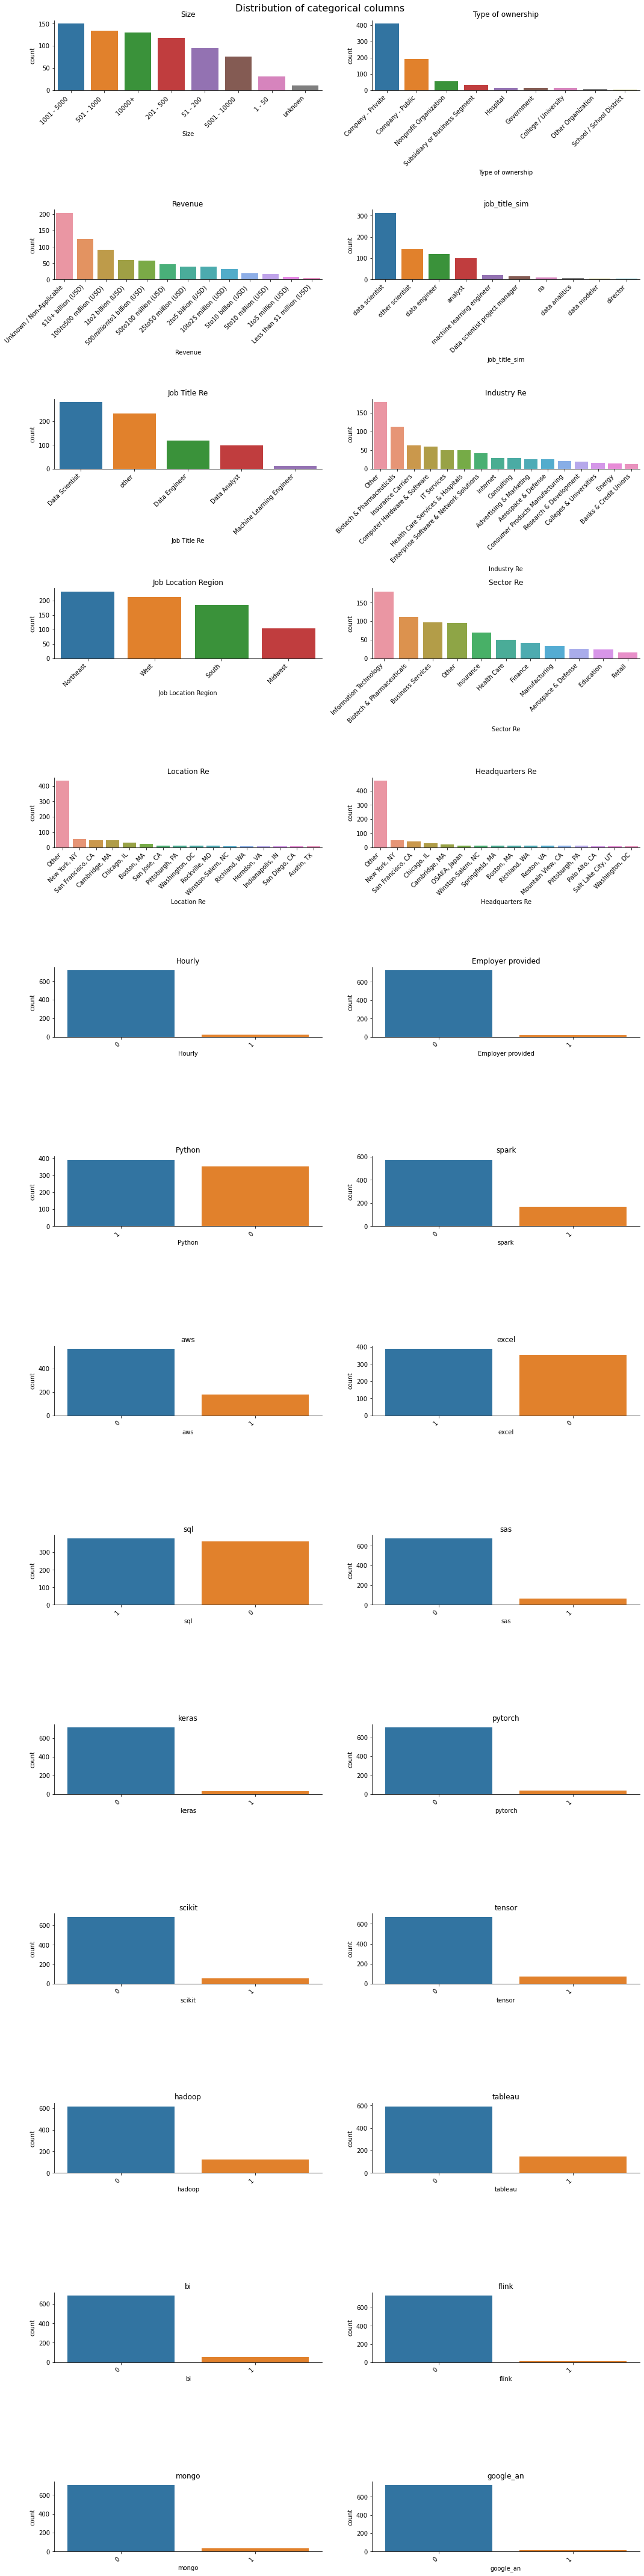

In [53]:
fig, axes = plt.subplots(14, 2, figsize=(15, 60))
axes = axes.flatten()
for idx, column in enumerate(cat_columns):
    #axes[idx].bar(x=df[column].value_counts().index, height=df[column].value_counts())
    sns.countplot(ax=axes[idx], x=column, data=df, order=df[column].value_counts().index)
    axes[idx].set_xticklabels(df[column].value_counts().index, rotation=45, ha="right")
    axes[idx].set_title(column)
    sns.despine()
fig.suptitle('Distribution of categorical columns \n', fontsize=16, y=0.99)
plt.tight_layout()
plt.show()

# Numeric Columns

Let's do a small feature engineering exercise on the `Salary` column. Let's create the difference in salary.

In [54]:
df['Salary difference'] = df['Upper Salary'] - df['Lower Salary']

In [55]:
num_col = df.select_dtypes(exclude=['object']).columns.tolist()

In [56]:
num_columns = [x for x in num_col if (x not in col_to_swap)]

In [57]:
num_columns

['Rating',
 'Founded',
 'Lower Salary',
 'Upper Salary',
 'Avg Salary(K)',
 'Age',
 'Salary difference']

In [58]:
len(num_columns)

7

We have 7 numerical columns. Let's have a look at their distribution (histograms).

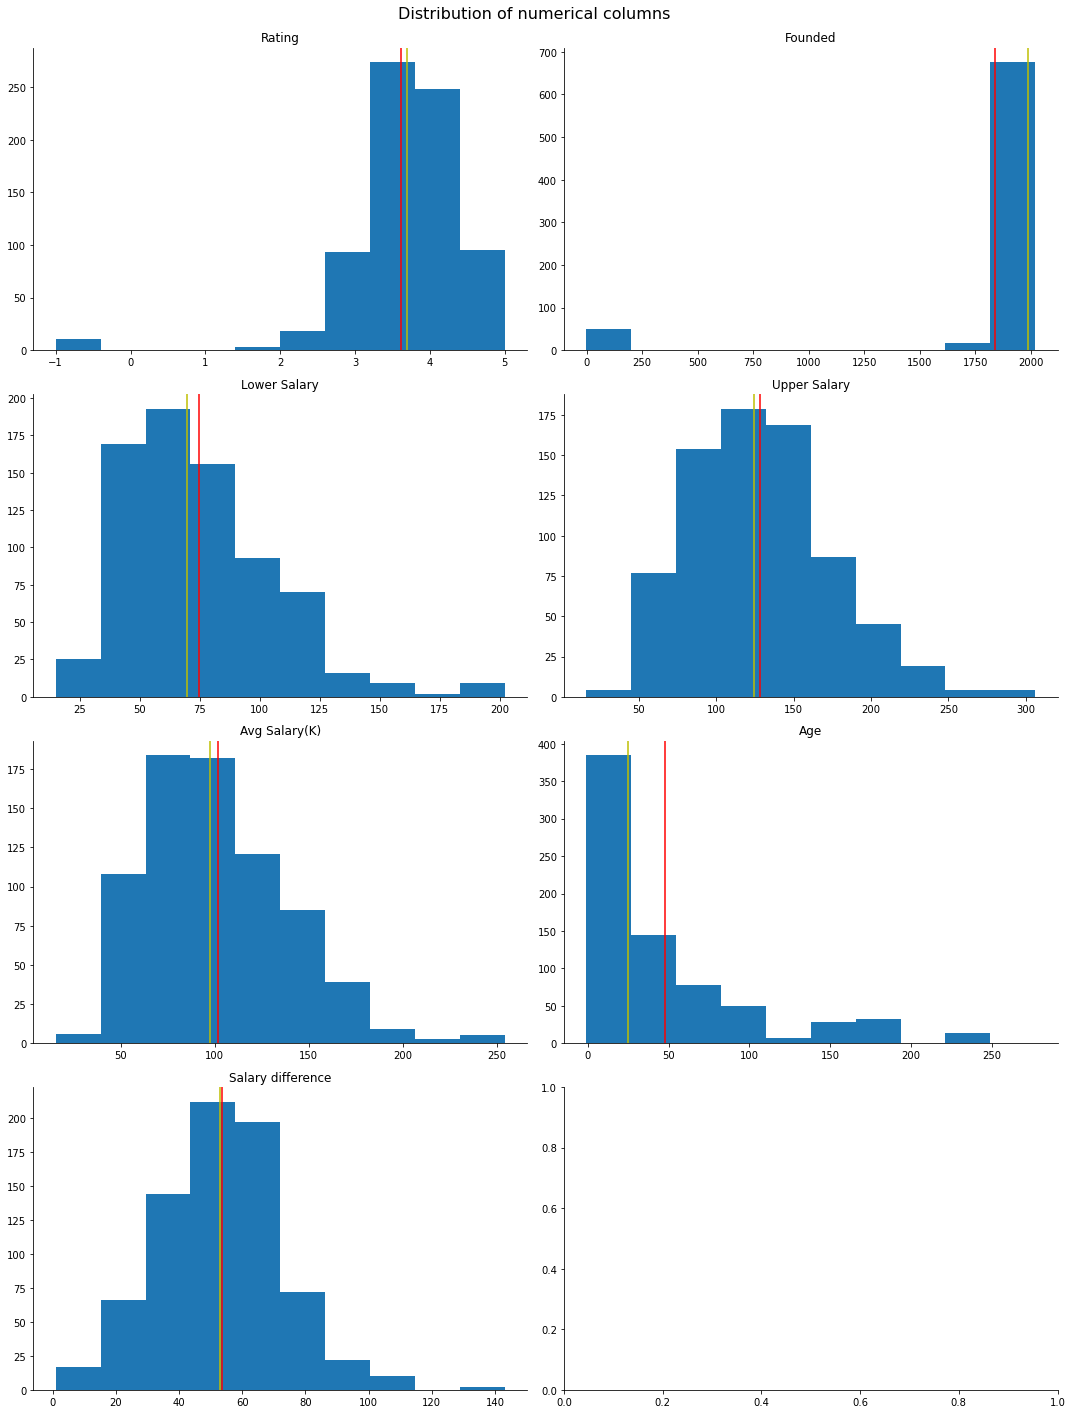

In [59]:
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()
for idx, column in enumerate(num_columns):
    axes[idx].hist(df[column])
    axes[idx].axvline(x=df[column].mean(), color='r')
    axes[idx].axvline(x=df[column].median(), color='y')
    axes[idx].set_title(column)
    sns.despine()
fig.suptitle('Distribution of numerical columns \n', fontsize=16)
plt.tight_layout()
plt.show()

We can see that some columns are affected by outliers. For this reason, we have created the class `RemoveOutliers` to pass into the pipeline and column transformers.

We are now going to transform the categorical columns using `OneHotEncoder` and the numerical columns using our class to remove the outliers and a `MinMaxScaler`.

- Numeric Data --> `RemoveOtliers()` --> `MinMaxScaler()`
- Categorical Data --> `OneHotEncoder()`

# Create the pipelines

In [60]:
numeric_transformer = Pipeline(steps=[("outlier_remove", RemoveOutliers()),
                                      ("scaler", MinMaxScaler())])
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_columns),
        ("cat", categorical_transformer, cat_columns)])

In [61]:
df_trandformed = preprocessor.fit_transform(df)

In [62]:
df_trandformed.toarray()

array([[0.57142857, 0.97965261, 0.19521479, ..., 0.        , 1.        ,
        0.        ],
       [0.38095238, 0.98511166, 0.30396955, ..., 0.        , 1.        ,
        0.        ],
       [1.        , 0.99801489, 0.48885264, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.        , 0.98511166, 0.22784122, ..., 0.        , 1.        ,
        0.        ],
       [0.28571429, 0.        , 0.65198477, ..., 0.        , 1.        ,
        0.        ],
       [0.47619048, 0.97667494, 0.2822186 , ..., 0.        , 1.        ,
        0.        ]])

In [63]:
df_trandformed.shape

(742, 152)

The trasformed dataset has now 152 columns (from 41 initially).

# Visualizing the Data

Before running our clustering analysis we would like to visualize the data. Because we have 152 columns, it's impossible to visually see this distribution.

Principal Component Analysis (PCA) will help us in visualizing the data.

We can visualize the data along the first two principal components (2D) or three principal components (3D). These are the directions that explain the majority of the variance.

In [64]:
df.columns

Index(['Rating', 'Size', 'Founded', 'Type of ownership', 'Revenue', 'Hourly',
       'Employer provided', 'Lower Salary', 'Upper Salary', 'Avg Salary(K)',
       'Age', 'Python', 'spark', 'aws', 'excel', 'sql', 'sas', 'keras',
       'pytorch', 'scikit', 'tensor', 'hadoop', 'tableau', 'bi', 'flink',
       'mongo', 'google_an', 'job_title_sim', 'Job Title Re', 'Industry Re',
       'Job Location Region', 'Sector Re', 'Location Re', 'Headquarters Re',
       'Salary difference'],
      dtype='object')

In [65]:
pca = PCA()
df_pca = pca.fit_transform(df_trandformed.toarray())

In [66]:
df_pca.shape

(742, 152)

We can visualize the data in 2D along PC1 and PC2.

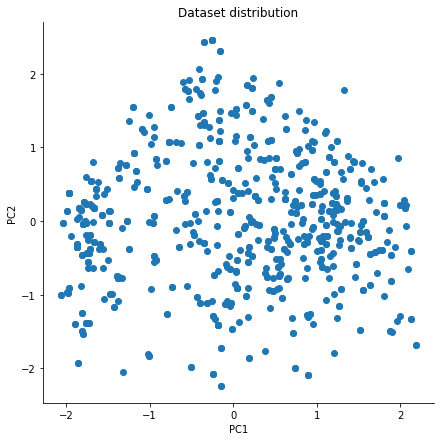

In [67]:
plt.figure(figsize=(7, 7))
plt.scatter(df_pca[:, 0], df_pca[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Dataset distribution')
sns.despine()
plt.show()

Looking in 2D we don't see clear clusters (groups).

Let's look at them in 3D.

In [68]:
fig = px.scatter_3d(x=df_pca[:, 0], y=df_pca[:, 1], z=df_pca[:, 2])
fig.update_traces(marker_size = 3)
fig.show()

It looks like in 3D we have a better idea of possbile clusters:

- One on top
- One or two in the lower part

# Clustering

We will use the `KMeans` algorithm for clustering. We will try a range of clusters from 1 to 30 and we look at inertia (and apply the elbow rule) and silohouette score to picke the best number of clusters.

### KMeans

In [69]:
inertia = []
silhouette = []
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(df_trandformed)
    inertia.append(np.sqrt(kmeans.inertia_))
    if k > 1:
        silhouette.append(silhouette_score(df_trandformed, kmeans.labels_))

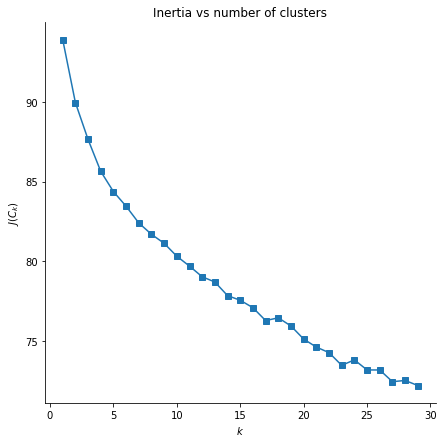

In [70]:
plt.figure(figsize=(7, 7))
plt.plot(range(1, 30), inertia, marker='s')
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')
plt.title('Inertia vs number of clusters')
sns.despine()
plt.show()

In the Inertia-number of clusters plot we don't see a clear elbow. 

Also the the highest silhouette score seems to refer to the 28 clusters.

In [71]:
df_results = pd.DataFrame(silhouette, index=range(2, 30), columns=['Silhouette Score']).reset_index()
df_results.rename(columns={'index': 'n_cluster'}, inplace=True)

In [72]:
df_results.sort_values("Silhouette Score", ascending=False).head()

n_cluster  Silhouette Score
27         29          0.126376
25         27          0.124356
26         28          0.119735
21         23          0.118730
23         25          0.118186

We can also try the `DBSCAN` algorithm and check if we get better results.

### DBSCAN

In [73]:
silhouette = []
eps = np.arange(1, 11)*0.1
for e in eps:
    dbdcan = DBSCAN(eps=e).fit(df_trandformed)
    silhouette.append(silhouette_score(df_trandformed, dbdcan.labels_))

In [74]:
df_results = pd.DataFrame(silhouette, index=eps, columns=['Silhouette Score']).reset_index()
df_results.rename(columns={'index': 'epsilon'}, inplace=True)

In [75]:
df_results.sort_values("Silhouette Score", ascending=False)

epsilon  Silhouette Score
0      0.1         -0.059608
4      0.5         -0.063408
5      0.6         -0.063408
6      0.7         -0.063408
7      0.8         -0.063408
8      0.9         -0.063408
9      1.0         -0.063408
2      0.3         -0.074429
3      0.4         -0.074429
1      0.2         -0.078308

It doesn't look like we are going to be able to use this algorithm. The Silhouette score are very low.

We will continue with `KMeans`. We'll choose a number of cluster based on what we saw in the 3D distribution of the data. It looked like 3 clusters could have been a good guess.

## Best KMeans Model

Let's fit the model with three clusters.

In [76]:
km_model = KMeans(n_clusters=3, random_state=101)
km_model.fit(df_trandformed)

KMeans(n_clusters=3, random_state=101)

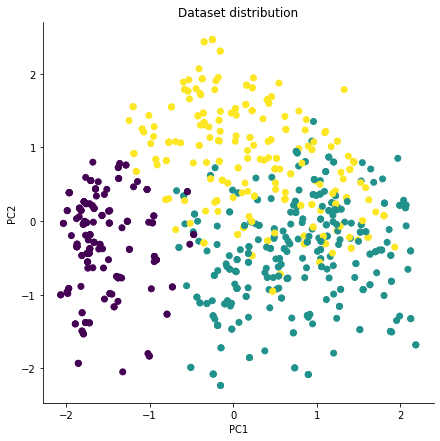

In [77]:
plt.figure(figsize=(7, 7))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=km_model.labels_)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Dataset distribution')
sns.despine()
plt.show()

In [78]:
fig = px.scatter_3d(x=df_pca[:, 0], y=df_pca[:, 1], z=df_pca[:, 2], color=km_model.labels_)
fig.update_traces(marker_size = 3)
fig.show()

In the 3D plot we can see a good separation between the three clusters.

Let's see what these three clusters look like.

# Model Evaluation

We'll first take the orginal dataframe (before the transformation), we'll remove the outliers and add the colum of labels from clustering.

In [79]:
df2 = df.copy()
for col in num_columns:
            df2[col] = df2[col].apply(lambda row: row if row > df2[col].quantile(0.1) else df2[col].quantile(0.1))
            df2[col] = df2[col].apply(lambda row: row if row < df2[col].quantile(0.95) else df2[col].quantile(0.95))

In [80]:
df2['Class Prediction'] = km_model.labels_

In [81]:
num_classes = df2['Class Prediction'].nunique()

In [82]:
df2.head()

Rating          Size  Founded   Type of ownership  \
index                                                      
0         3.8   501 - 1000    1973.0   Company - Private   
1         3.4       10000+    1984.0  Other Organization   
2         4.7   501 - 1000    2010.0   Company - Private   
3         3.8  1001 - 5000    1965.0          Government   
4         2.9     51 - 200    1998.0   Company - Private   

                                Revenue  Hourly  Employer provided  \
index                                                                
0             $50 to $100 million (USD)       0                  0   
1                $2 to $5 billion (USD)       0                  0   
2            $100 to $500 million (USD)       0                  0   
3      $500 million to $1 billion (USD)       0                  0   
4              Unknown / Non-Applicable       0                  0   

       Lower Salary  Upper Salary  Avg Salary(K)  ...  google_an  \
index                                             ...              
0              53.0          91.0           72.0  ...          0   
1              63.0         112.0           87.5  ...          0   
2              80.0          90.0           85.0  ...          0   
3              56.0          97.0           76.5  ...          0   
4              86.0         143.0          114.5  ...          0   

        job_title_sim    Job Title Re                       Industry Re  \
index                                                                     
0      data scientist  Data Scientist               Aerospace & Defense   
1      data scientist  Data Scientist  Health Care Services & Hospitals   
2      data scientist  Data Scientist                             Other   
3      data scientist  Data Scientist                            Energy   
4      data scientist  Data Scientist           Advertising & Marketing   

       Job Location Region            Sector Re   Location Re  \
index                                                           
0                     West  Aerospace & Defense         Other   
1                    South          Health Care         Other   
2                    South    Business Services         Other   
3                     West                Other  Richland, WA   
4                Northeast    Business Services  New York, NY   

       Headquarters Re  Salary difference  Class Prediction  
index                                                        
0                Other               38.0                 1  
1                Other               49.0                 1  
2                Other               29.0                 1  
3         Richland, WA               41.0                 1  
4         New York, NY               57.0                 1  

[5 rows x 36 columns]

Let's see what the means of the numeric columns in the three clusters look like.

In [83]:
df2.groupby('Class Prediction').mean().T

Class Prediction             0            1            2
Rating                3.459043     3.799026     3.765447
Founded            1943.914894  1967.155844  1973.304878
Hourly                0.117021     0.000000     0.008130
Employer provided     0.053191     0.016234     0.008130
Lower Salary         63.590426    89.097403    62.674797
Upper Salary        117.957447   146.587662   112.548780
Avg Salary(K)        90.726064   117.991883    87.707317
Age                  60.952128    45.116883    36.829268
Python                0.079787     0.811688     0.516260
spark                 0.000000     0.282468     0.325203
aws                   0.079787     0.266234     0.321138
excel                 0.457447     0.493506     0.609756
sql                   0.005319     0.600649     0.788618
sas                   0.010638     0.162338     0.056911
keras                 0.000000     0.094156     0.000000
pytorch               0.005319     0.123377     0.000000
scikit                0.000000     0.175325     0.000000
tensor                0.005319     0.220779     0.012195
hadoop                0.000000     0.194805     0.260163
tableau               0.010638     0.246753     0.284553
bi                    0.010638     0.090909     0.105691
flink                 0.000000     0.012987     0.024390
mongo                 0.000000     0.061688     0.073171
google_an             0.000000     0.009740     0.044715
Salary difference    54.207447    56.938312    49.199187

Even better, we can look at the distributions of the numeric columns in the three clusters. 

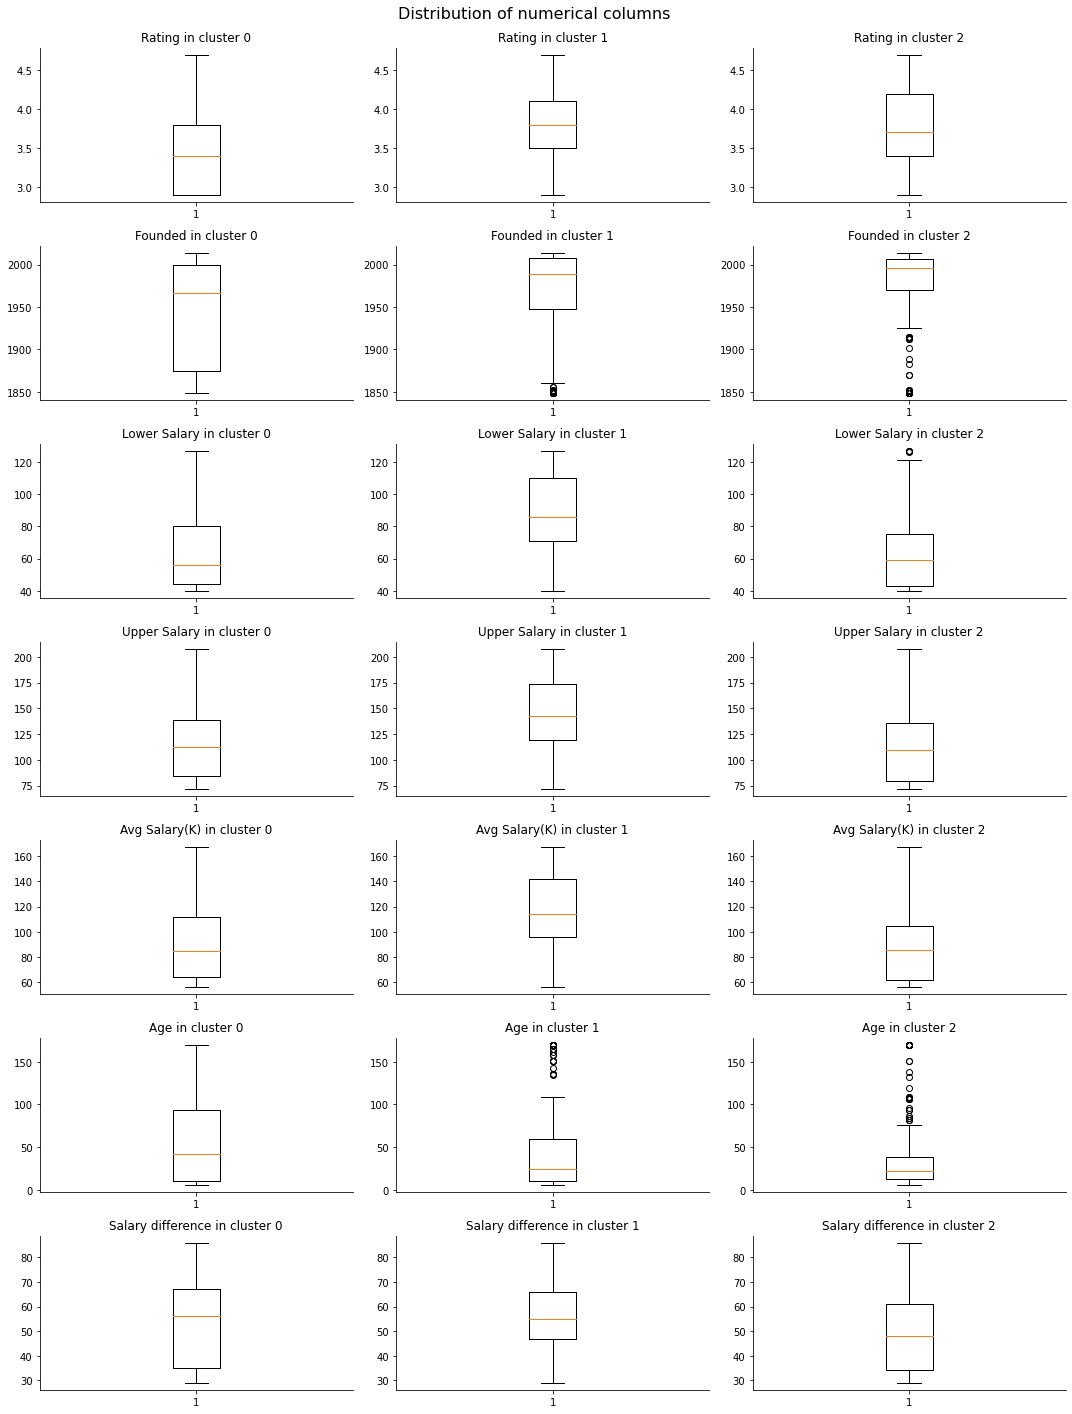

In [84]:
fig, axes = plt.subplots(len(num_columns), num_classes, figsize=(15, 20))

for idx, column in enumerate(num_columns):
    for class_ in range(num_classes):
        temp_df = df2[df2['Class Prediction'] == class_]
        axes[idx][class_].boxplot(temp_df[column])
        axes[idx][class_].set_title(f'{column} in cluster {class_}')
        sns.despine()
fig.suptitle('Distribution of numerical columns \n', fontsize=16)
plt.tight_layout()
plt.show()

It looks like:

- Cluster 0: lower rating, older company, lower average salary, older or better distributed age of employees
- Cluster 1: higher rating, yonger company, higher average salary, younger employees
- Cluster2: very similar to cluster 0 with younger company and younger employees

Let's look at the required skills for the clusters.

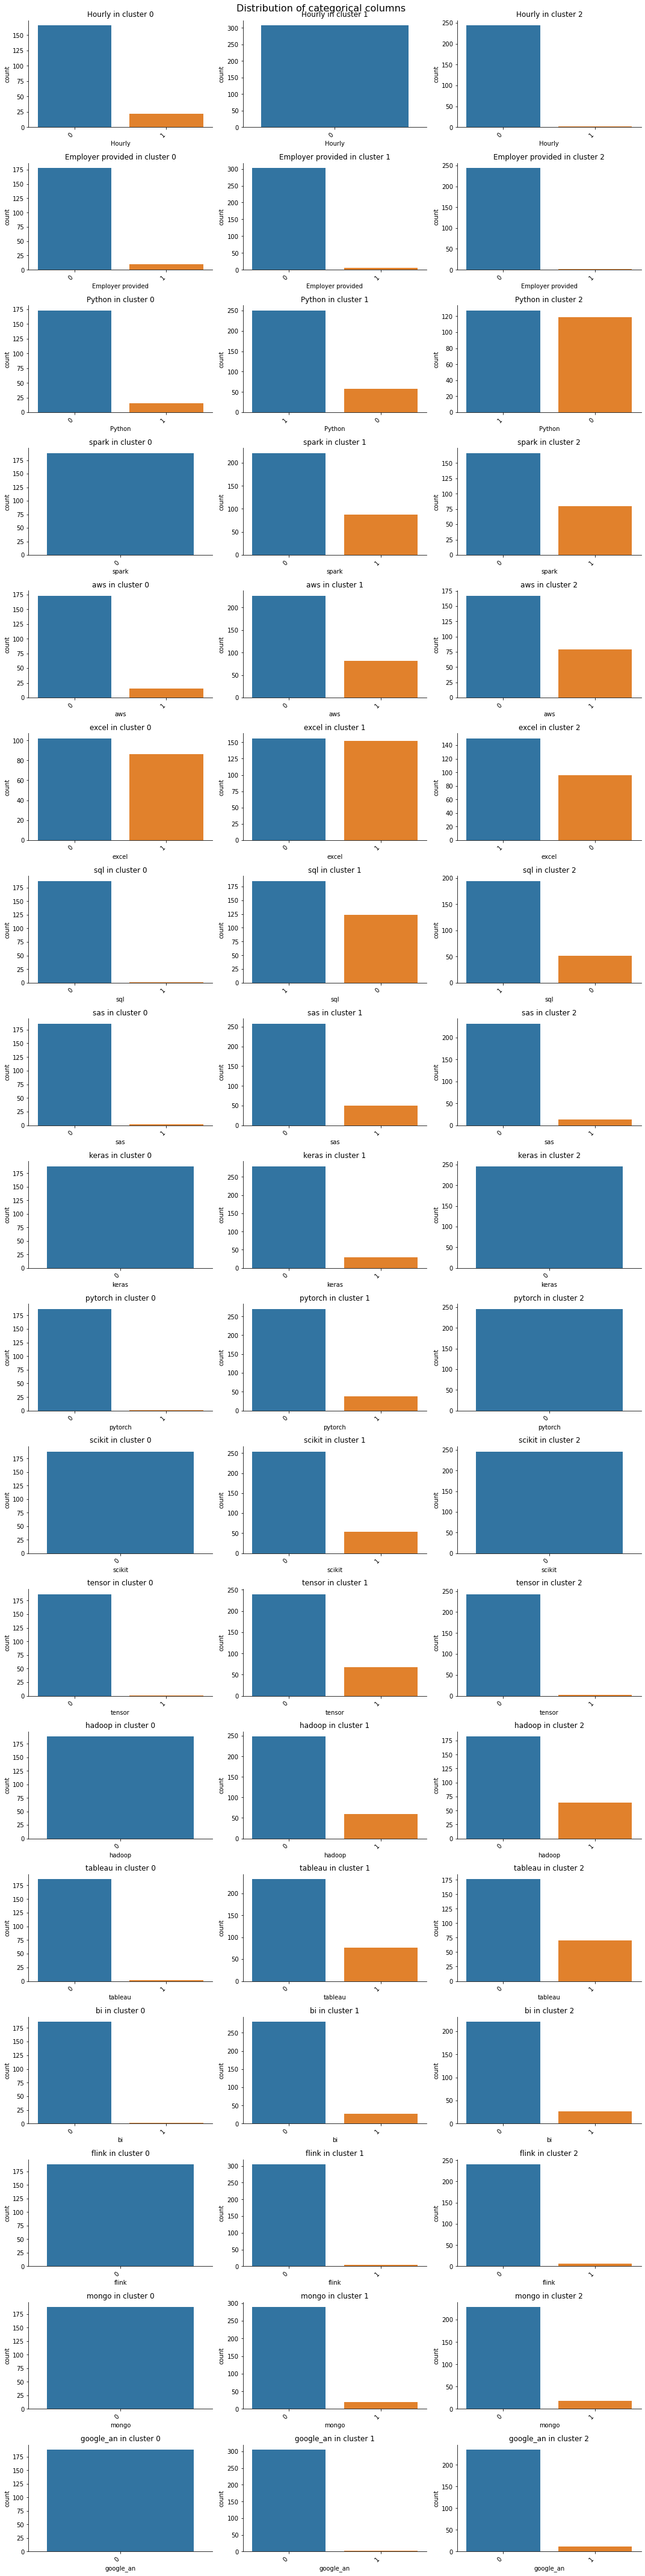

In [85]:
fig, axes = plt.subplots(len(col_to_swap), num_classes, figsize=(15, 60))

for idx, column in enumerate(col_to_swap):
    for class_ in range(num_classes):
        temp_df = df2[df2['Class Prediction'] == class_]
        sns.countplot(ax=axes[idx][class_], x=column, data=temp_df, order=temp_df[column].value_counts().index)
        axes[idx][class_].set_xticklabels(temp_df[column].value_counts().index, rotation=45, ha="right")
        axes[idx][class_].set_title(f'{column} in cluster {class_}')
        sns.despine()
fig.suptitle('Distribution of categorical columns \n', fontsize=16, y=0.99)
plt.tight_layout()
plt.show()

Looking at the skills it looks like:

- Cluster 0 doesn't require any particular technical skills
- Cluster 1 is more technical and require the use of Python, SQL and some Excel
- Cluster 2 is somewhat technical, it requires SQL, Excel and some Python 

Let's see what these clusters look like in term of job titles.

In [87]:
df2[df2['Class Prediction'] == 2]['Job Title Re'].value_counts()

Data Engineer                118
Data Analyst                  93
other                         31
Machine Learning Engineer      4
Name: Job Title Re, dtype: int64

In [88]:
df2[df2['Class Prediction'] == 1]['Job Title Re'].value_counts()

Data Scientist               274
other                         28
Machine Learning Engineer      6
Name: Job Title Re, dtype: int64

In [89]:
df2[df2['Class Prediction'] == 0]['Job Title Re'].value_counts()

other                        174
Data Analyst                   6
Data Scientist                 5
Machine Learning Engineer      2
Data Engineer                  1
Name: Job Title Re, dtype: int64

Based on the job titles it looks like:

- CLASS 0 --> General position
- CLASS 1 --> Data Scientist
- CLASS 2 --> Data Engineer

## Recommendations

It would be interesting to see what happens if we dropped `Job Title Re` column from the dataset to check if the clusters would remain the same without the information in the training data.

It would also be interesting to look into the cost of living of the cities and try to get some useful information for clustering.

Most important, we left some columns behind. We should go back and try to extract some usuful information from those to see how that would influence the algorithm.